# RTI Race code

* Exploring options to determine processing rules for RTI Race code
* check for NA's (besides 0 unknown)
* entries with commas should change to 0 for our denom files

In [1]:
## Load packages ----
import numpy as np
import pandas as pd
import sshtunnel
import psycopg2 as pg
import os
import seaborn as sns
import matplotlib.pyplot as plt

/n/home_fasse/laurenflynn/.conda/envs/dorieh/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
## Open ssh tunnel to DB host ----
tunnel = sshtunnel.SSHTunnelForwarder(
    ('nsaph.rc.fas.harvard.edu', 22),
    ssh_username=f'{os.environ["MY_NSAPH_SSH_USERNAME"]}',
    ssh_private_key=f'{os.environ["HOME"]}/.ssh/id_rsa', 
    ssh_password=f'{os.environ["MY_NSAPH_SSH_PASSWORD"]}', 
    remote_bind_address=("localhost", 5432)
)

tunnel.start()

In [3]:
## Open connection to DB ----
connection = pg.connect(
    host='localhost',
    database='nsaph2',
    user=f'{os.environ["MY_NSAPH_DB_USERNAME"]}',
    password=f'{os.environ["MY_NSAPH_DB_PASSWORD"]}', 
    port=tunnel.local_bind_port
)

## Unique RTI race code counts

## Unique race code counts

## Combinations of rate and RTI race

In [4]:
sql_query = f"""SELECT bene_id, race, race_rti, (race=race_rti) AS matching FROM medicare.beneficiaries;"""

In [5]:
sql_query

'SELECT bene_id, race, race_rti, (race=race_rti) AS matching FROM medicare.beneficiaries;'

In [6]:
## Request query ----
df = pd.read_sql_query(sql_query, connection, index_col = 'bene_id').reset_index()

| code | race | rti_race |
|-|-|--|
|0| Unknown | Unknown |
|1| White | Non-Hispanic White |
|2| Black | Black/African-American |
|3| Other | Other |
|4| Asian | Asian/Pacific Islander |
|5| Hispanic | Hispanic |
|6| North American Native | American Indian/Alaska Native |


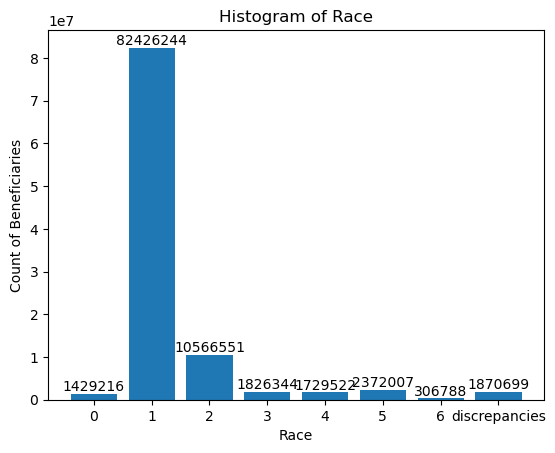

In [7]:
# Create a new column 'race_grouped' with desired categories
df['race_grouped'] = df['race'].map(lambda x: str(x) if str(x) in ['0', '1', '2', '3', '4', '5', '6'] else 'discrepancies')

# Calculate value counts for 'race_grouped' column and specify the desired order
unique_race_grouped_counts = df['race_grouped'].value_counts().loc[['0', '1', '2', '3', '4', '5', '6', 'discrepancies']]

# Plot the histogram with modified categories and ordered x-axis
plt.bar(range(len(unique_race_grouped_counts)), unique_race_grouped_counts, tick_label=unique_race_grouped_counts.index)

# Add value counts on top of the bars
for i, count in enumerate(unique_race_grouped_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Add labels and title
plt.xlabel('Race')
plt.ylabel('Count of Beneficiaries')
plt.title('Histogram of Race')
plt.show()

We can see with the RTI race codes, a greater proportion of individuals identify as Hispanic than in the origin race codes. We can also see there are a greater number of discrepancies.

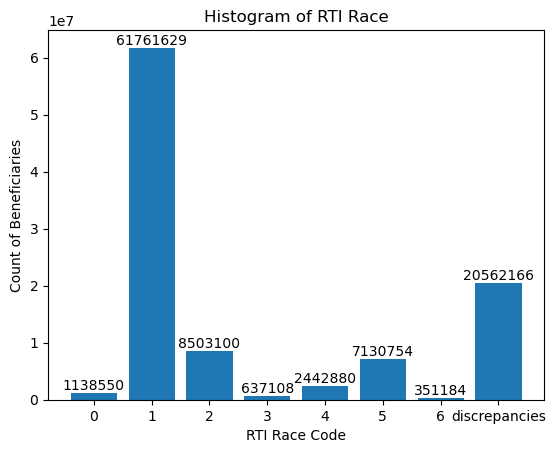

In [8]:
#same as above but using rti race codes
# Create a new column 'race_grouped' with desired categories
df['race_rti_grouped'] = df['race_rti'].map(lambda x: str(x) if str(x) in ['0', '1', '2', '3', '4', '5', '6'] else 'discrepancies')

# Calculate value counts for 'race_rti_grouped' column and specify the desired order
unique_race_rti_grouped_counts = df['race_rti_grouped'].value_counts().loc[['0', '1', '2', '3', '4', '5', '6', 'discrepancies']]

# Plot the histogram with modified categories and ordered x-axis
plt.bar(range(len(unique_race_rti_grouped_counts)), unique_race_rti_grouped_counts, tick_label=unique_race_rti_grouped_counts.index)

# Add value counts on top of the bars
for i, count in enumerate(unique_race_rti_grouped_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Add labels and title
plt.xlabel('RTI Race Code')
plt.ylabel('Count of Beneficiaries')
plt.title('Histogram of RTI Race')
plt.show()

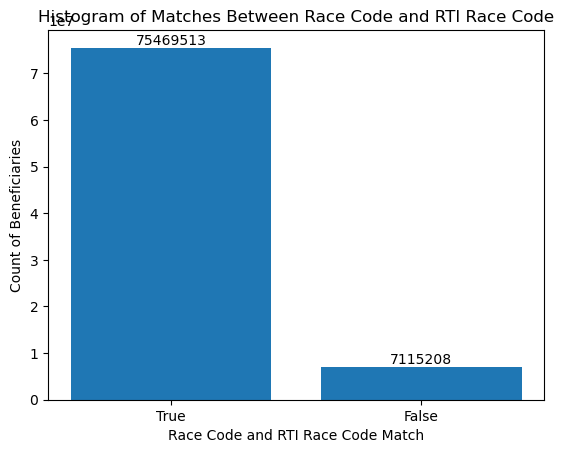

In [9]:
match_counts = df['matching'].value_counts()

plt.bar(range(len(match_counts)), match_counts)

# Add value counts on top of the bars
for i, count in enumerate(match_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Set the tick labels using the value counts index
plt.xticks(range(len(match_counts)), match_counts.index)

# Add labels and title
plt.xlabel('Race Code and RTI Race Code Match')
plt.ylabel('Count of Beneficiaries')
plt.title('Histogram of Matches Between Race Code and RTI Race Code')

# Display the histogram
plt.show()


In [10]:
7115208/75469513

0.09427923564313977

About 9% of the codes from the original race code do not match the RTI race code. 

In [12]:
mismatch = df[df['matching'] == False]

In [25]:
combination_counts = mismatch.groupby(['race', 'race_rti']).size().reset_index(name='count')
combination_counts = combination_counts.sort_values(by='count', ascending=False)
combination_counts.head(n=20)

,race,race_rti,count
109,1,5,3801226
321,3,4,518212
324,3,5,407842
352,"3,5",5,289499
154,"1,3",1,285136
335,"3,4",4,256153
257,2,5,163458
169,"1,3",5,159327
106,1,4,130912
10,0,5,124735
